In [181]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import *

import numpy as np


def conv3x3(in_planes, out_planes, stride=1, dilation=1, padding='same'):
    """3x3 convolution with padding"""
    if padding == 'same':
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, bias=False, dilation=dilation)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1,
                 kernel_size=3,
                 norm_layer=None):
        super(ResBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.shortcut_conv = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride)
        self.conv1 = nn.Conv2d(inplanes, planes // 2, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(planes // 2, planes // 2, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2)
        self.conv3 = nn.Conv2d(planes // 2, planes, kernel_size=1, stride=1, padding=0)

        self.normalizer_fn = norm_layer(planes)
        self.activation_fn = nn.ReLU(inplace=True)

        self.stride = stride
        self.out_planes = planes

    def forward(self, x):
        shortcut = x
        (_, _, _, x_planes) = x.size()

        if self.stride != 1 or x_planes != self.out_planes:
            shortcut = self.shortcut_conv(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x += shortcut
        x = self.normalizer_fn(x)
        x = self.activation_fn(x)

        return x


class ResFCN256(nn.Module):
    def __init__(self, resolution_input=256, resolution_output=256, channel=3, size=16):
        super().__init__()
        self.input_resolution = resolution_input
        self.output_resolution = resolution_output
        self.channel = channel
        self.size = size

        # Encoder
        self.block0 = conv3x3(in_planes=3, out_planes=self.size, padding='same')
        self.block1 = ResBlock(inplanes=self.size, planes=self.size * 2, stride=2)
        self.block2 = ResBlock(inplanes=self.size * 2, planes=self.size * 2, stride=1)
        self.block3 = ResBlock(inplanes=self.size * 2, planes=self.size * 4, stride=2)
        self.block4 = ResBlock(inplanes=self.size * 4, planes=self.size * 4, stride=1)
        self.block5 = ResBlock(inplanes=self.size * 4, planes=self.size * 8, stride=2)
        self.block6 = ResBlock(inplanes=self.size * 8, planes=self.size * 8, stride=1)
        self.block7 = ResBlock(inplanes=self.size * 8, planes=self.size * 16, stride=2)
        self.block8 = ResBlock(inplanes=self.size * 16, planes=self.size * 16, stride=1)
        self.block9 = ResBlock(inplanes=self.size * 16, planes=self.size * 32, stride=2)
        self.block10 = ResBlock(inplanes=self.size * 32, planes=self.size * 32, stride=1)

        # Decoder
        self.upsample0 = nn.ConvTranspose2d(self.size * 32, self.size * 32, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.
        self.upsample1 = nn.ConvTranspose2d(self.size * 32, self.size * 16, kernel_size=4, stride=2,
                                            padding=1)  # half downsample.
        self.upsample2 = nn.ConvTranspose2d(self.size * 16, self.size * 16, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.
        self.upsample3 = nn.ConvTranspose2d(self.size * 16, self.size * 16, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.

        self.upsample4 = nn.ConvTranspose2d(self.size * 16, self.size * 8, kernel_size=4, stride=2,
                                            padding=1)  # half downsample.
        self.upsample5 = nn.ConvTranspose2d(self.size * 8, self.size * 8, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.
        self.upsample6 = nn.ConvTranspose2d(self.size * 8, self.size * 8, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.

        self.upsample7 = nn.ConvTranspose2d(self.size * 8, self.size * 4, kernel_size=4, stride=2,
                                            padding=1)  # half downsample.
        self.upsample8 = nn.ConvTranspose2d(self.size * 4, self.size * 4, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.
        self.upsample9 = nn.ConvTranspose2d(self.size * 4, self.size * 4, kernel_size=3, stride=1,
                                            padding=1)  # keep shape invariant.

        self.upsample10 = nn.ConvTranspose2d(self.size * 4, self.size * 2, kernel_size=4, stride=2,
                                             padding=1)  # half downsample.
        self.upsample11 = nn.ConvTranspose2d(self.size * 2, self.size * 2, kernel_size=3, stride=1,
                                             padding=1)  # keep shape invariant.

        self.upsample12 = nn.ConvTranspose2d(self.size * 2, self.size, kernel_size=4, stride=2,
                                             padding=1)  # half downsample.
        self.upsample13 = nn.ConvTranspose2d(self.size, self.size, kernel_size=3, stride=1,
                                             padding=1)  # keep shape invariant.

        self.upsample14 = nn.ConvTranspose2d(self.size, self.channel, kernel_size=3, stride=1,
                                             padding=1)  # keep shape invariant.
        self.upsample15 = nn.ConvTranspose2d(self.channel, self.channel, kernel_size=3, stride=1,
                                             padding=1)  # keep shape invariant.
        self.upsample16 = nn.ConvTranspose2d(self.channel, self.channel, kernel_size=3, stride=1,
                                             padding=1)  # keep shape invariant.

        # ACT
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        se = self.block0(x)  # 256 x 256 x 16
        se = self.block1(se)  # 128 x 128 x 32
        se = self.block2(se)  # 128 x 128 x 32
        se = self.block3(se)  # 64 x 64 x 64
        se = self.block4(se)  # 64 x 64 x 64
        se = self.block5(se)  # 32 x 32 x 128
        se = self.block6(se)  # 32 x 32 x 128
        se = self.block7(se)  # 16 x 16 x 256
        se = self.block8(se)  # 16 x 16 x 256
        se = self.block9(se)  # 8 x 8 x 512
        se = self.block10(se)  # 8 x 8 x 512

        pd = self.upsample0(se)  # 8 x 8 x 512
        pd = self.upsample1(pd)  # 16 x 16 x 256
        pd = self.upsample2(pd)  # 16 x 16 x 256
        pd = self.upsample3(pd)  # 16 x 16 x 256
        pd = self.upsample4(pd)  # 32 x 32 x 128
        pd = self.upsample5(pd)  # 32 x 32 x 128
        pd = self.upsample6(pd)  # 32 x 32 x 128
        pd = self.upsample7(pd)  # 64 x 64 x 64
        pd = self.upsample8(pd)  # 64 x 64 x 64
        pd = self.upsample9(pd)  # 64 x 64 x 64

        pd = self.upsample10(pd)  # 128 x 128 x 32
        pd = self.upsample11(pd)  # 128 x 128 x 32
        pd = self.upsample12(pd)  # 256 x 256 x 16
        pd = self.upsample13(pd)  # 256 x 256 x 16
        pd = self.upsample14(pd)  # 256 x 256 x 3
        pd = self.upsample15(pd)  # 256 x 256 x 3
        pos = self.upsample16(pd)  # 256 x 256 x 3

        pos = self.sigmoid(pos)
        return pos

In [182]:
import torch
import numpy as np
#from model.resfcn256 import ResFCN256


class PRN:
    '''
        <Joint 3D Face Reconstruction and Dense Alignment with Position Map Regression Network>
        This class serves as the wrapper of PRNet.
    '''

    def __init__(self, model_dir, **kwargs):
        # resolution of input and output image size.
        self.resolution_inp = kwargs.get("resolution_inp") or 256
        self.resolution_op = kwargs.get("resolution_op") or 256
        self.channel = kwargs.get("channel") or 3
        self.size = kwargs.get("size") or 16

        self.uv_kpt_ind_path = kwargs.get("uv_kpt_path") or "utils/uv_data/uv_kpt_ind.txt"
        self.face_ind_path = kwargs.get("face_ind_path") or "utils/uv_data/face_ind.txt"
        self.triangles_path = kwargs.get("triangles_path") or "utils/uv_data/triangles.txt"

        # 1) load model.
        self.pos_predictor = ResFCN256()
        state = torch.load(model_dir)
        self.pos_predictor.load_state_dict(state['prnet'])
        self.pos_predictor.eval()  # inference stage only.
        if torch.cuda.device_count() > 0:
            self.pos_predictor = self.pos_predictor.to("cuda")

        # 2) load uv_file.
        self.uv_kpt_ind = np.loadtxt(self.uv_kpt_ind_path).astype(np.int32)  # 2 x 68 get kpt
        self.face_ind = np.loadtxt(self.face_ind_path).astype(np.int32)  # get valid vertices in the pos map
        self.triangles = np.loadtxt(self.triangles_path).astype(np.int32)  # ntri x 3

        self.uv_coords = self.generate_uv_coords()

    def net_forward(self, image):
        ''' The core of out method: regress the position map of a given image.
        Args:
            image: (3, 256, 256) array. value range: 0~1
        Returns:
            pos: the 3D position map. (3, 256, 256) array.
        '''
        return self.pos_predictor(image)

    def generate_uv_coords(self):
        resolution = self.resolution_op
        uv_coords = np.meshgrid(range(resolution), range(resolution))
        uv_coords = np.transpose(np.array(uv_coords), [1, 2, 0])
        uv_coords = np.reshape(uv_coords, [resolution ** 2, -1])
        uv_coords = uv_coords[self.face_ind, :]
        uv_coords = np.hstack((uv_coords[:, :2], np.zeros([uv_coords.shape[0], 1])))
        return uv_coords

    def get_landmarks(self, pos):
        '''
        Notice: original tensorflow version shape is [256, 256, 3] (H, W, C)
                where our pytorch shape is [3, 256, 256] (C, H, W).
        Args:
            pos: the 3D position map. shape = (256, 256, 3).
        Returns:
            kpt: 68 3D landmarks. shape = (68, 3).
        '''
        kpt = pos[self.uv_kpt_ind[1, :], self.uv_kpt_ind[0, :], :]
        return kpt

    def get_vertices(self, pos):
        '''
        Args:
            pos: the 3D position map. shape = (3, 256, 256).
        Returns:
            vertices: the vertices(point cloud). shape = (num of points, 3). n is about 40K here.
        '''
        all_vertices = np.reshape(pos, [self.resolution_op ** 2, -1])
        vertices = all_vertices[self.face_ind, :]

        return vertices

In [183]:
prn = PRN(model_dir = 'results/latest.pth')

In [184]:
def get_data(DATA_DIR, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], image_size = 256):
    full_dataset = dset.ImageFolder(root=DATA_DIR,
                           transform=transforms.Compose([
                                      transforms.Resize(image_size),
                                      # transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std),
                                  ]))
    return full_dataset

def make_loaders(dataset, batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size)

    return test_loader

In [185]:
DATA_DIR = r'up2/'  # looking in sub folder
batch_size = 1

In [186]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [222]:
data_folder = get_data(DATA_DIR)
data_loader = make_loaders(data_folder, batch_size)

In [223]:
with torch.no_grad():
  image,_ = next(iter(data_loader))
  image = image.to("cuda")
  output = prn.net_forward(image)

In [224]:
#print(output)
print(output.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
FLAGS = {"start_epoch": 0,
         "target_epoch": 500,
         "device": "cuda",
         "mask_path": "./utils/uv_data/uv_weight_mask_gdh.png",
         "lr": 0.0001,
         "batch_size": 16,
         "save_interval": 5,
         "normalize_mean": [0.485, 0.456, 0.406],
         "normalize_std": [0.229, 0.224, 0.225],
         "images": "./results",
         "gauss_kernel": "original",
         "summary_path": "./prnet_runs",
         "summary_step": 0,
         "resume": True}

In [190]:
import matplotlib.pyplot as plt

In [225]:
out = output[0].cpu().detach().numpy()
pos = np.squeeze(out)
cropped_pos = pos * 255
pos = cropped_pos.transpose(1, 2, 0)

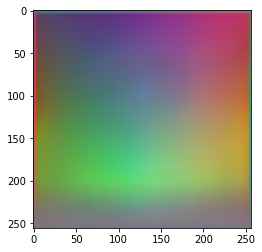

In [213]:
plt.imshow(out.transpose(1,2,0))

In [193]:
import numpy as np
import cv2

end_list = np.array([17, 22, 27, 42, 48, 31, 36, 68], dtype=np.int32) - 1


def plot_kpt(image, kpt):
    ''' Draw 68 key points
    Args: 
        image: the input image
        kpt: (68, 3).
    '''
    image = image.copy()
    kpt = np.round(kpt).astype(np.int32)
    for i in range(kpt.shape[0]):
        st = kpt[i, :2]
        image = cv2.circle(image, (st[0], st[1]), 1, (0, 0, 255), 2)
        if i in end_list:
            continue
        ed = kpt[i + 1, :2]
        image = cv2.line(image, (st[0], st[1]), (ed[0], ed[1]), (255, 255, 255), 1)
    return image


def plot_vertices(image, vertices):
    image = image.copy()
    vertices = np.round(vertices).astype(np.int32)
    for i in range(0, vertices.shape[0], 2):
        st = vertices[i, :2]
        image = cv2.circle(image, (st[0], st[1]), 1, (255, 0, 0), -1)
    return image


def plot_pose_box(image, P, kpt, color=(0, 255, 0), line_width=2):
    ''' Draw a 3D box as annotation of pose. Ref:https://github.com/yinguobing/head-pose-estimation/blob/master/pose_estimator.py
    Args: 
        image: the input image
        P: (3, 4). Affine Camera Matrix.
        kpt: (68, 3).
    '''
    image = image.copy()

    point_3d = []
    rear_size = 90
    rear_depth = 0
    point_3d.append((-rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, -rear_size, rear_depth))

    front_size = 105
    front_depth = 110
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d.append((-front_size, front_size, front_depth))
    point_3d.append((front_size, front_size, front_depth))
    point_3d.append((front_size, -front_size, front_depth))
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d = np.array(point_3d, dtype=np.float).reshape(-1, 3)

    # Map to 2d image points
    point_3d_homo = np.hstack((point_3d, np.ones([point_3d.shape[0], 1])))  # n x 4
    point_2d = point_3d_homo.dot(P.T)[:, :2]
    point_2d[:, :2] = point_2d[:, :2] - np.mean(point_2d[:4, :2], 0) + np.mean(kpt[:27, :2], 0)
    point_2d = np.int32(point_2d.reshape(-1, 2))

    # Draw all the lines
    cv2.polylines(image, [point_2d], True, color, line_width, cv2.LINE_AA)
    cv2.line(image, tuple(point_2d[1]), tuple(
        point_2d[6]), color, line_width, cv2.LINE_AA)
    cv2.line(image, tuple(point_2d[2]), tuple(
        point_2d[7]), color, line_width, cv2.LINE_AA)
    cv2.line(image, tuple(point_2d[3]), tuple(
        point_2d[8]), color, line_width, cv2.LINE_AA)

    return image

In [226]:
kpt = prn.get_landmarks(pos)

In [195]:
import numpy as np
from math import cos, sin, atan2, asin


def isRotationMatrix(R):
    ''' checks if a matrix is a valid rotation matrix(whether orthogonal or not)
    '''
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


def matrix2angle(R):
    ''' compute three Euler angles from a Rotation Matrix. Ref: http://www.gregslabaugh.net/publications/euler.pdf
    Args:
        R: (3,3). rotation matrix
    Returns:
        x: yaw
        y: pitch
        z: roll
    '''
    # assert(isRotationMatrix(R))

    if R[2, 0] != 1 or R[2, 0] != -1:
        x = asin(R[2, 0])
        y = atan2(R[2, 1] / cos(x), R[2, 2] / cos(x))
        z = atan2(R[1, 0] / cos(x), R[0, 0] / cos(x))

    else:  # Gimbal lock
        z = 0  # can be anything
        if R[2, 0] == -1:
            x = np.pi / 2
            y = z + atan2(R[0, 1], R[0, 2])
        else:
            x = -np.pi / 2
            y = -z + atan2(-R[0, 1], -R[0, 2])

    return x, y, z

def P2sRt(P):
    ''' decompositing camera matrix P. 
    Args: 
        P: (3, 4). Affine Camera Matrix.
    Returns:
        s: scale factor.
        R: (3, 3). rotation matrix.
        t2d: (2,). 2d translation. 
    '''
    t2d = P[:2, 3]
    R1 = P[0:1, :3]
    R2 = P[1:2, :3]
    s = (np.linalg.norm(R1) + np.linalg.norm(R2)) / 2.0
    r1 = R1 / np.linalg.norm(R1)
    r2 = R2 / np.linalg.norm(R2)
    r3 = np.cross(r1, r2)

    R = np.concatenate((r1, r2, r3), 0)
    return s, R, t2d

def compute_similarity_transform(points_static, points_to_transform):
    # http://nghiaho.com/?page_id=671
    p0 = np.copy(points_static).T
    p1 = np.copy(points_to_transform).T

    t0 = -np.mean(p0, axis=1).reshape(3, 1)
    t1 = -np.mean(p1, axis=1).reshape(3, 1)
    t_final = t1 - t0

    p0c = p0 + t0
    p1c = p1 + t1

    covariance_matrix = p0c.dot(p1c.T)
    U, S, V = np.linalg.svd(covariance_matrix)
    R = U.dot(V)
    if np.linalg.det(R) < 0:
        R[:, 2] *= -1

    rms_d0 = np.sqrt(np.mean(np.linalg.norm(p0c, axis=0) ** 2))
    rms_d1 = np.sqrt(np.mean(np.linalg.norm(p1c, axis=0) ** 2))

    s = (rms_d0 / rms_d1)
    P = np.c_[s * np.eye(3).dot(R), t_final]
    return P

def estimate_pose(vertices):
    canonical_vertices = np.load('utils/uv_data/canonical_vertices.npy')
    P = compute_similarity_transform(vertices, canonical_vertices)
    _, R, _ = P2sRt(P)  # decompose affine matrix to s, R, t
    pose = matrix2angle(R)

    return P, pose

In [227]:
vertices = prn.get_vertices(pos)

In [228]:
camera_matrix, pose = estimate_pose(vertices)

In [229]:
image = cv2.imread('up2/imgs/01019.png')
image = cv2.resize(image, (256, 256))

In [218]:
image.shape

(256, 256, 3)

In [219]:
from google.colab.patches import cv2_imshow

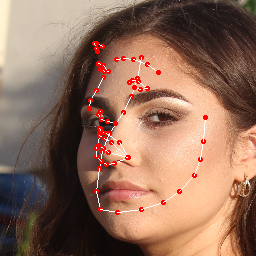

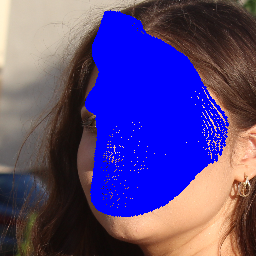

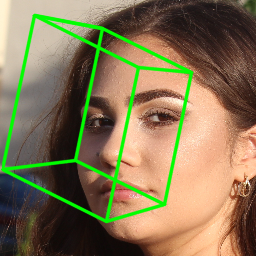

In [230]:
cv2_imshow(plot_kpt(image, kpt))
cv2_imshow(plot_vertices(image, vertices))
cv2_imshow(plot_pose_box(image, camera_matrix, kpt))

In [ ]:
# image_pose = plot_pose_box(image, camera_matrix, kpt)
# cv2.imshow('sparse alignment', plot_kpt(image, kpt))
# cv2.imshow('dense alignment', plot_vertices(image, vertices))
# cv2.imshow('pose', plot_pose_box(image, camera_matrix, kpt))
# cv2.waitKey()